In [19]:
import os
import xarray as xr
import numpy as np
import geopandas as gpd
import pandas as pd
from memoryraster import MemoryRaster

era5_file = "79a080c8aaa9b3f1d4808e650202035c.nc"
ERA5_VARIABLE_MAPPINGS = {"2m_temperature": "t2m"}

# Columns to keep in zonal statistics output
ADM_COLS = ["ADM1_PCODE","ADM1_EN", "ADM2_PCODE", "ADM2_EN"]

city_polygons = gpd.read_file("data/vnm_adm_gov_20201027/vnm_admbnda_adm2_gov_20201027.shp").to_crs("EPSG:4326")
population_high = MemoryRaster.read("data/vnm_ppp_2020_UNadj_constrained.tif", crs="EPSG:4326")

In [23]:
city_polygons[ADM_COLS]

,ADM1_PCODE,ADM1_EN,ADM2_PCODE,ADM2_EN
0,VN411,Thua Thien Hue,VN41115,A Luoi
1,VN813,Kien Giang,VN81315,An Bien
2,VN103,Hai Phong city,VN10313,An Duong
3,VN603,Gia Lai,VN60311,An Khe
4,VN103,Hai Phong city,VN10315,An Lao
...,...,...,...,...
703,VN106,Bac Ninh,VN10603,Yen Phong
704,VN211,Tuyen Quang,VN21109,Yen Son
705,VN403,Nghe An,VN40323,Yen Thanh
706,VN221,Bac Giang,VN22103,Yen The


In [2]:
def get_extents(gdf: gpd.GeoDataFrame) -> tuple[slice, slice]:
    min_long, min_lat, max_long, max_lat = gdf.geometry.total_bounds
    return slice(int(min_long), int(max_long) + 1), slice(int(max_lat+1), int(min_lat))

In [3]:
population_masked_high_m = population_high.mask(city_polygons).astype(np.float32)
population_masked_high_m

<MemoryRaster (17796, 8789) CRS=EPSG:4326 min=1.0159043073654175 max=28730.828125 NODATA=0 file=None
  transform=| 0.00, 0.00, 102.15|
| 0.00,-0.00, 23.39|
| 0.00, 0.00, 1.00|>

In [82]:
def era5_raster(ds: xr.Dataset, variable: str, gdf: gpd.GeoDataFrame) -> xr.DataArray:
    varname = ERA5_VARIABLE_MAPPINGS.get(variable, variable)
    data = ds[varname]

    # ERA5 stores longitude from the 0 to 360 scale
    # with 0 at the Greenwich meridian, counting east
    data.coords['longitude'] = (data.coords['longitude'] + 180) % 360 - 180
    data = data.sortby(data.longitude)
    # crop to geometry extent
    extent_long, extent_lat = get_extents(gdf)
    return data.sel(longitude = extent_long, latitude = extent_lat)

era5 = xr.open_dataset(era5_file)
ds = era5_raster(era5, '2m_temperature', city_polygons)

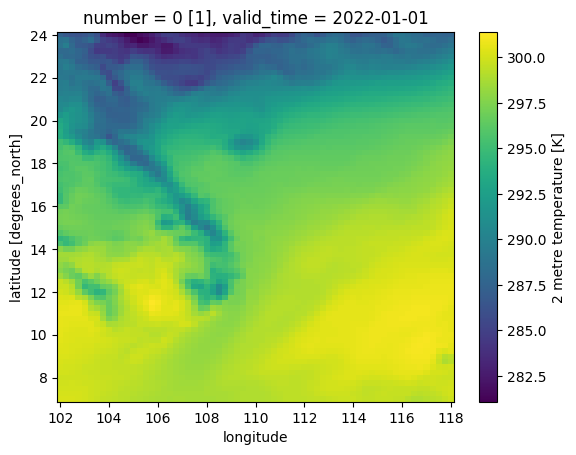

In [5]:
vietnam_weather = era5_raster(era5_file, '2m_temperature', city_polygons).sel(valid_time="2022-01-01")
vietnam_weather.plot(x="longitude")

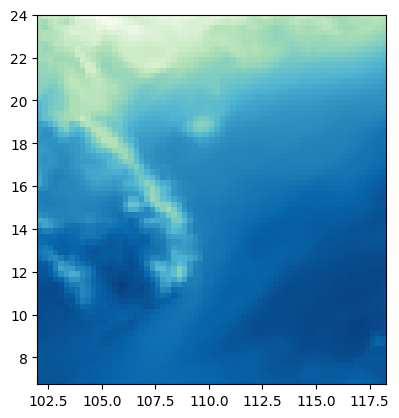

<Axes: >

In [6]:
weather_m = MemoryRaster.from_xarray(vietnam_weather)
weather_m.plot()

Resampling using: 13


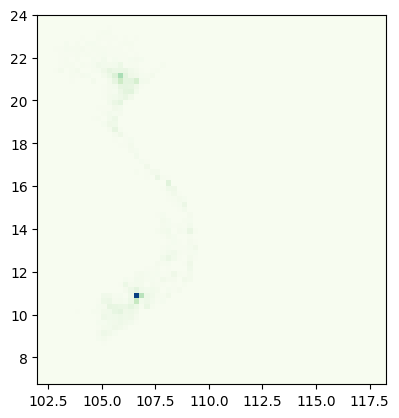

<Axes: >

In [7]:
from rasterio.enums import Resampling
population_m = population_masked_high_m.resample(weather_m, Resampling.sum)
population_m.plot()

In [11]:
zs = weather_m.zonal_stats(city_polygons, 'mean(coverage_weight=area_spherical_m2)', weights=population_m, include_cols=["ADM2_EN", "ADM1_EN"], include_geom=True)

/Users/abhidg/ghq/github.com/kraemer-lab/DART-Aggregation/.venv/lib/python3.13/site-packages/exactextract/exact_extract.py:330: RuntimeWarning: Spatial reference system of input features does not exactly match raster.
  warnings.warn(
/Users/abhidg/ghq/github.com/kraemer-lab/DART-Aggregation/.venv/lib/python3.13/site-packages/exactextract/exact_extract.py:341: RuntimeWarning: Spatial reference system of input features does not exactly match weighting raster.
  warnings.warn(


In [13]:
city_polygons.columns

Index(['Shape_Leng', 'Shape_Area', 'ADM2_EN', 'ADM2_VI', 'ADM2_PCODE',
       'ADM2_REF', 'ADM2ALT1EN', 'ADM2ALT2EN', 'ADM2ALT1VI', 'ADM2ALT2VI',
       'ADM1_EN', 'ADM1_VI', 'ADM1_PCODE', 'ADM0_EN', 'ADM0_VI', 'ADM0_PCODE',
       'date', 'validOn', 'validTo', 'geometry'],
      dtype='object')

In [133]:
from tqdm.notebook import tqdm
def yearly_era5_zonal_statistics(dataset: xr.Dataset, variable: str, gdf: gpd.GeoDataFrame, population: MemoryRaster, statistic: str, operation: str = 'mean(coverage_weight=area_spherical_m2)') -> pd.DataFrame:
    da = era5_raster(dataset, variable, gdf)
    min_date = da.valid_time.min().dt.date.item(0)
    max_date = da.valid_time.max().dt.date.item(0)

    # Empty dataframe with output columns
    out = pd.DataFrame(data = [], columns=ADM_COLS + ["value", "date"])

    for date in tqdm(pd.date_range(min_date, datetime.date(2022,6,30), inclusive="both")):
        arr = da.sel(valid_time = date.isoformat())
        rast = MemoryRaster.from_xarray(arr)
        df = rast.zonal_stats(city_polygons, operation, weights=population, include_cols=ADM_COLS).rename(columns={"mean": "value"})
        df['date'] = date
        out = pd.concat([out, df])
    out['metric'] = f'era5.{variable}.{statistic}'
    out['isoweek'] = out['date'].dt.isocalendar().year.astype(str) + '-W' + out['date'].dt.isocalendar().week.astype(str).str.zfill(2)
    return out
    

In [134]:
df = yearly_era5_zonal_statistics(era5, '2m_temperature', city_polygons, population_m, statistic='daily_mean')

  0%|          | 0/181 [00:00<?, ?it/s]

/Users/abhidg/ghq/github.com/kraemer-lab/DART-Aggregation/.venv/lib/python3.13/site-packages/exactextract/exact_extract.py:330: RuntimeWarning: Spatial reference system of input features does not exactly match raster.
  warnings.warn(
/Users/abhidg/ghq/github.com/kraemer-lab/DART-Aggregation/.venv/lib/python3.13/site-packages/exactextract/exact_extract.py:341: RuntimeWarning: Spatial reference system of input features does not exactly match weighting raster.
  warnings.warn(
/var/folders/2t/8v1v9w8s191f91fnq_f9t0600000gn/T/ipykernel_75308/3075861186.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  out = pd.concat([out, df])
/Users/abhidg/ghq/github.com/kraemer-lab/DART-Aggregation/.venv/lib/python3.13/site-packages/exactextract/exact_ex

In [136]:
df.groupby(ADM_COLS + ['isoweek']).value.mean().reset_index().sort_values('isoweek')

,ADM1_PCODE,ADM1_EN,ADM2_PCODE,ADM2_EN,isoweek,value
0,VN101,Ha Noi,VN10101,Ba Dinh,2021-W52,290.048492
13770,VN701,Ho Chi Minh city,VN70141,Nha Be,2021-W52,300.323789
2727,VN115,Thai Binh,VN11503,Quynh Phu,2021-W52,290.423515
13797,VN701,Ho Chi Minh city,VN70143,Can Gio,2021-W52,300.078122
18603,VN819,Soc Trang,VN81912,Nga Nam,2021-W52,299.832390
...,...,...,...,...,...,...
12176,VN603,Gia Lai,VN60323,Krong Pa,2022-W26,300.523287
12149,VN603,Gia Lai,VN60322,Ia Pa,2022-W26,300.450921
12122,VN603,Gia Lai,VN60321,Ayun Pa,2022-W26,300.729844
12338,VN605,Dak Lak,VN60505,Ea Sup,2022-W26,300.881043
